In [1]:
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload
%matplotlib inline
import matplotlib.pyplot as plt

# always import gbm_algos first !
import xgboost, lightgbm, catboost
from gplearn.genetic import SymbolicRegressor

# To access the contents of the parent dir
import sys; sys.path.insert(0, '../')
import os
from scipy.io import loadmat
from utils import *
from preprocess import *
from models import RobustPCANN

# Let's do facy optimizers
from optimizers import Lookahead, AdamGC, SGDGC
from madgrad import MADGRAD
from lbfgsnew import LBFGSNew

from pytorch_robust_pca import *

# Modify at /usr/local/lib/python3.9/site-packages/torch_lr_finder/lr_finder.py
from torch_lr_finder import LRFinder

# Tracking
from tqdm import trange

# Symbolics
import sympy
import sympytorch

# BayesianOptimization
from bayes_opt import BayesianOptimization
from skopt import Optimizer

# hyperopt
from hyperopt import hp, fmin, tpe

Running Python 3.9.8
You can use npar for np.array


In [2]:
DATA_PATH = "../experimental_data/burgers_shock.mat"
data = loadmat(DATA_PATH)

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

# Adding noise
noise_intensity = 0.01
noisy_xt = False
sub = False

if noise_intensity>0.0:
    Exact = perturb(Exact, intensity=noise_intensity, noise_type="normal")
    print("Perturbed Exact with intensity =", float(noise_intensity))
else: print("Clean Exact")

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]

if noisy_xt and noise_intensity>0.0:
    print("Noisy (x, t)")
    X_star = perturb(X_star, intensity=noise_intensity, noise_type="normal")
else: print("Clean (x, t)")

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)

N = 2000
print(f"Training with {N} samples")
idx = np.random.choice(X_star.shape[0], N, replace=False)
X_u_train = X_star[idx, :]
u_train = u_star[idx,:]

if sub:
    print("โหลดทับ")
    X_u_train = np.load("./data_files/X_u_train_1000labeledsamples.npy")[:N, :]
    u_train = np.load("./data_files/u_train_1000labeledsamples.npy")

# Convert to torch.tensor
X_u_train = to_tensor(X_u_train, True)
u_train = to_tensor(u_train, False)

scaling_factor = 1.0
lb = scaling_factor*to_tensor(lb, False)
ub = scaling_factor*to_tensor(ub, False)

# Feature names, base on the symbolic regression results
feature_names = ('uf', 'u_x', 'u_xx'); feature2index = {}

Perturbed Exact with intensity = 0.01
Clean (x, t)
Training with 2000 samples


In [3]:
if u_train.shape[0] == 2000:
    ### Noiseless 2000 labeled samples program ###
    program = '''
    -0.970158*uf*u_x+0.003090*u_xx
    '''
elif u_train.shape[0] == 1000:
    ### Noiseless 1000 labeled samples program ###
    program = '''
    -0.860374*uf*u_x+0.002631*u_xx
    '''
else: program = None

pde_expr, variables = build_exp(program); print(pde_expr, variables)
mod = sympytorch.SymPyModule(expressions=[pde_expr]); mod.train()

-0.970158*u_x*uf + 0.00309*u_xx {uf, u_xx, u_x}


SymPyModule(expressions=(-0.970158*u_x*uf + 0.00309*u_xx,))

In [4]:
list(mod.parameters())[0], list(mod.parameters())[1]

(Parameter containing:
 tensor(0.0031, requires_grad=True),
 Parameter containing:
 tensor(-0.9702, requires_grad=True))

In [5]:
class RobustPINN(nn.Module):
    def __init__(self, model, loss_fn, index2features, scale=False, lb=None, ub=None, pretrained=False, noiseless_mode=True, init_cs=(0.5, 0.5), init_betas=(0.0, 0.0)):
        super(RobustPINN, self).__init__()
        self.model = model
        if not pretrained: self.model.apply(self.xavier_init)
        
        self.noiseless_mode = noiseless_mode
        self.in_fft_nn = None; self.out_fft_nn = None
        self.inp_rpca = None; self.out_rpca = None
        if not self.noiseless_mode:
            # FFTNN
            self.in_fft_nn = FFTTh(c=init_cs[0])
            self.out_fft_nn = FFTTh(c=init_cs[1])

            # Robust Beta-PCA
            self.inp_rpca = RobustPCANN(beta=init_betas[0], is_beta_trainable=True, inp_dims=2, hidden_dims=32)
            self.out_rpca = RobustPCANN(beta=init_betas[1], is_beta_trainable=True, inp_dims=1, hidden_dims=32)
        
        self.p0 = torch.log(list(loss_fn.parameters())[0])
        self.p1 = list(loss_fn.parameters())[1]
        # To update self.p0, uncomment the code below.
        # To properly train actually...
        # self.p0 = nn.Parameter(self.p0.data)
        # self.p1 = nn.Parameter(self.p1.data)
        
        self.index2features = index2features; self.feature2index = {}
        for idx, fn in enumerate(self.index2features): self.feature2index[fn] = str(idx)
        self.scale = scale; self.lb, self.ub = lb, ub
        self.diff_flag = diff_flag(self.index2features)
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, x, t):
        H = torch.cat([x, t], dim=1)
        if self.scale: H = self.neural_net_scale(H)
        return self.model(H)
    
    def loss(self, X_input, X_input_noise, y_input, y_input_noise, exp_p0=True, update_network_params=True, update_pde_params=True):
        # Denoising process
        if not self.noiseless_mode:
            # (1) Denoising FFT on (x, t)
            # This line returns the approx. recon.
            X_input_noise = cat(torch.fft.ifft(self.in_fft_nn(X_input_noise[1])*X_input_noise[0]).real.reshape(-1, 1), 
                                torch.fft.ifft(self.in_fft_nn(X_input_noise[3])*X_input_noise[2]).real.reshape(-1, 1))
            X_input_noise = X_input-X_input_noise
            X_input = self.inp_rpca(X_input, X_input_noise, normalize=True)
            
            # (2) Denoising FFT on y_input
            y_input_noise = y_input-torch.fft.ifft(self.out_fft_nn(y_input_noise[1])*y_input_noise[0]).real.reshape(-1, 1)
            y_input = self.out_rpca(y_input, y_input_noise, normalize=True)
        
        grads_dict, u_t = self.grads_dict(X_input[:, 0:1], X_input[:, 1:2])
        
        total_loss = []
        # MSE Loss
        if update_network_params:
            mse_loss = F.mse_loss(grads_dict["uf"], y_input)
            total_loss.append(mse_loss)
            
        # PDE Loss
        if update_pde_params:
            if exp_p0: p0_coeff = torch.exp(self.p0)
            else: p0_coeff = self.p0
            l_eq = F.mse_loss(p0_coeff*grads_dict["u_xx"]+self.p1*grads_dict["uf"]*grads_dict["u_x"], u_t)
            total_loss.append(l_eq)
            
        return total_loss
    
    def grads_dict(self, x, t):
        uf = self.forward(x, t)
        u_t = self.gradients(uf, t)[0]
        u_x = self.gradients(uf, x)[0]
        u_xx = self.gradients(u_x, x)[0]
        
        return {"uf":uf, "u_x":u_x, "u_xx":u_xx}, u_t
    
    def gradients(self, func, x):
        return grad(func, x, create_graph=True, retain_graph=True, grad_outputs=torch.ones(func.shape))
    
    def neural_net_scale(self, inp): 
        return -1.0+2.0*(inp-self.lb)/(self.ub-self.lb)

In [6]:
model = TorchMLP(dimensions=[2, 50, 50, 50 ,50, 50, 1], 
         activation_function=nn.Tanh, bn=None, # nn.LayerNorm
         dropout=None)

# Pretrained model
semisup_model_state_dict = torch.load("./weights_nobn/semisup_model_nobn_2000_2000_finetuned.pth")
parameters = OrderedDict()
# Filter only the parts that I care about renaming (to be similar to what defined in TorchMLP).
inner_part = "network.model."
for p in semisup_model_state_dict:
    if inner_part in p:
        parameters[p.replace(inner_part, "")] = semisup_model_state_dict[p]

model.load_state_dict(parameters)

Using old implementation of TorchMLP. See models.py for more new model-related source code.


<All keys matched successfully>

In [7]:
F.mse_loss(model(X_u_train), u_train)

tensor(6.2975e-05, grad_fn=<MseLossBackward0>)

In [8]:
NOISELESS_MODE = False

In [9]:
_, x_fft, x_PSD = fft1d_denoise(X_u_train[:, 0:1], c=-5, return_real=True)
_, t_fft, t_PSD = fft1d_denoise(X_u_train[:, 1:2], c=-5, return_real=True)
_, u_train_fft, u_train_PSD = fft1d_denoise(u_train, c=-5, return_real=True)

In [10]:
def closure():
    global NOISELESS_MODE
    if torch.is_grad_enabled():
        optimizer2.zero_grad()
    losses = pinn.loss(X_u_train, (x_fft, x_PSD, t_fft, t_PSD), u_train, (u_train_fft, u_train_PSD), exp_p0=True, update_network_params=True, update_pde_params=True)
    l = sum(losses)
    if l.requires_grad:
        l.backward(retain_graph=True)
    return l

def mtl_closure():
    global NOISELESS_MODE
    losses = pinn.loss(X_u_train, (x_fft, x_PSD, t_fft, t_PSD), u_train, (u_train_fft, u_train_PSD), exp_p0=True, update_network_params=True, update_pde_params=True)
    updated_grads = []
    
    for i in range(len(losses)):
        optimizer1.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in pinn.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(pinn.parameters()): 
        param.grad = updated_grads[0][idx]+updated_grads[1][idx]
        
    return sum(losses)

In [11]:
if not NOISELESS_MODE:
    print("You are in noisy mode.")
    pinn = RobustPINN(model=model, loss_fn=mod, index2features=feature_names, 
                      scale=False, lb=None, ub=None, pretrained=True, noiseless_mode=NOISELESS_MODE)

    def inference(args):
        global pinn
        c1, c2 = args
        
        pinn.in_fft_nn.c = nn.Parameter(data=torch.FloatTensor([c1]), requires_grad=False)
        pinn.out_fft_nn.c = nn.Parameter(data=torch.FloatTensor([c2]), requires_grad=False)
        
        losses = pinn.loss(X_u_train, (x_fft, x_PSD, t_fft, t_PSD), u_train, (u_train_fft, u_train_PSD), update_network_params=True, update_pde_params=True)
        return sum(losses).item()

    pinn.eval()
    space = [hp.uniform('c1', 0, 5), hp.uniform('c2', 0, 5)]
    res = fmin(fn=inference, space=space, algo=tpe.suggest, max_evals=1000)

    print(res)
    if 'pinn' in globals(): del pinn

    pinn = RobustPINN(model=model, loss_fn=mod, index2features=feature_names, 
                      scale=False, lb=None, ub=None, pretrained=True, noiseless_mode=NOISELESS_MODE,
                      init_cs=(res['c1'], res['c2']), init_betas=(0.0, 0.0))
    
else: 
    pinn = RobustPINN(model=model, loss_fn=mod, index2features=feature_names, 
                      scale=False, lb=None, ub=None, pretrained=True, noiseless_mode=NOISELESS_MODE)
    print("You are in noiseless mode.")

You are in noisy mode.
100%|██████████| 1000/1000 [00:25<00:00, 39.03trial/s, best loss: 1.436251163482666]
{'c1': 2.43396951617593, 'c2': 3.152702874490893}


In [12]:
pinn = load_weights(pinn, "./pinn_weights/pinn_cleanob_cleanlabel.pth")

Loaded the model's weights with strict=False


In [13]:
X_star = to_tensor(X_star)
u_star = to_tensor(u_star)

In [14]:
xx, tt = X_star[:, 0:1], X_star[:, 1:2]
print(F.mse_loss(pinn(xx, tt), u_star))
uf = pinn(xx, tt)
uf = uf.detach().numpy().reshape(X.shape)

tensor(3.8029e-05, grad_fn=<MseLossBackward0>)


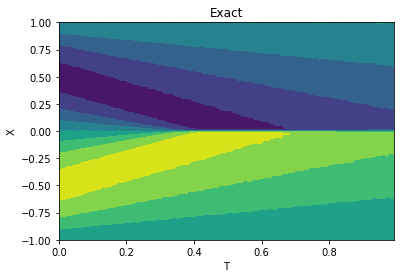

In [15]:
fig, ax = plt.subplots(1, 1)

# plots filled contour plot
ax.contourf(T, X, Exact)

ax.set_title('Exact')
ax.set_xlabel('T')
ax.set_ylabel('X')

plt.show()

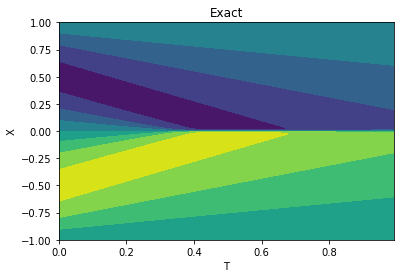

In [16]:
fig, ax = plt.subplots(1, 1)

# plots filled contour plot
ax.contourf(T, X, uf)

ax.set_title('Exact')
ax.set_xlabel('T')
ax.set_ylabel('X')

plt.show()

In [ ]:
epochs1, epochs2 = 10000, 50

In [ ]:
# optimizer1 = MADGRAD(pinn.parameters(), lr=1e-7, momentum=0.95)
optimizer1 = AdamGC(pinn.parameters(), lr=6e-4, use_gc=True, gc_conv_only=False, gc_loc=False)
pinn.train(); best_train_loss = 1e6

print('1st Phase optimization using Adam with PCGrad gradient modification')
for i in range(epochs1):
    optimizer1.step(mtl_closure)
    if (i % 1000) == 0 or i == epochs1-1:
        l = mtl_closure()
        print("Epoch {}: ".format(i), l.item())

In [ ]:
optimizer2 = torch.optim.LBFGS(pinn.parameters(), lr=1e-1, max_iter=500, max_eval=int(500*1.25), history_size=500, line_search_fn='strong_wolfe')
print('2nd Phase optimization using LBFGS')
for i in range(epochs2):
    optimizer2.step(closure)
    if (i % 10) == 0 or i == epochs2-1:
        l = closure()
        print("Epoch {}: ".format(i), l.item())

In [ ]:
float(np.exp(pinn.p0.detach().numpy())), float(pinn.p1.detach().numpy())

In [ ]:
save(pinn, "tmp.pth")
# pinn = load_weights(pinn, "tmp.pth")

In [ ]:
def closure():
    global NOISELESS_MODE
    if torch.is_grad_enabled():
        optimizer2.zero_grad()
    losses = pinn.loss(X_u_train, (x_fft, x_PSD, t_fft, t_PSD), u_train, (u_train_fft, u_train_PSD), exp_p0=False, update_network_params=True, update_pde_params=True)
    l = sum(losses)
    if l.requires_grad:
        l.backward(retain_graph=True)
    return l

def mtl_closure():
    global NOISELESS_MODE
    losses = pinn.loss(X_u_train, (x_fft, x_PSD, t_fft, t_PSD), u_train, (u_train_fft, u_train_PSD), exp_p0=False, update_network_params=True, update_pde_params=True)
    updated_grads = []
    
    for i in range(len(losses)):
        optimizer1.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in pinn.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(pinn.parameters()): 
        param.grad = updated_grads[0][idx]+updated_grads[1][idx]
        
    return sum(losses)

In [ ]:
pinn.p0 = nn.Parameter(data=torch.tensor(round(float(np.exp(pinn.p0.detach().numpy())), 4)))
pinn.p1 = nn.Parameter(data=torch.tensor(round(float(pinn.p1.detach().numpy()), 4)))
pinn.p0, pinn.p1

In [ ]:
del optimizer1

In [ ]:
optimizer1 = AdamGC(pinn.parameters(), lr=1e-6, use_gc=True, gc_conv_only=False, gc_loc=False)

In [ ]:
epochs = 1000
pinn.train()
for i in range(epochs):
    optimizer1.step(mtl_closure)
    if (i % 100) == 0 or i == epochs-1:
        l = mtl_closure()
        print("Epoch {}: ".format(i), l.item())
        print(float(pinn.p1.detach().numpy()), float((pinn.p0.detach().numpy())))

In [ ]:
epochs = 100
pinn.train()
for i in range(epochs):
    optimizer1.step(mtl_closure)
    if (i % 100) == 0 or i == epochs-1:
        l = mtl_closure()
        print("Epoch {}: ".format(i), l.item())
        print(float(pinn.p1.detach().numpy()), float((pinn.p0.detach().numpy())))

In [ ]:
### With/Without denoising layers ablation study ###

# pinn no ffth clean all
# (-1.00022292137146, 0.0031830661464482546)
# (0.011659960711956706, 0.01063217643403939)

# pinn no ffth clean ob noisy label
# (-1.0002213716506958, 0.003198811085894704)
# (0.2578756208767374, 0.2357384558071573)

# pinn no ffth noisy ob noisy label
# (-1.009460687637329 0.0032692295499145985)
# (1.8259720664182926, 0.8799033026853824)

### ----- ###
# pinn ffth clean all
# (-0.9994307160377502, 0.0031862353649783444)
# 0.07773227423228249

# pinn ffth clean ob noisy label
# (-1.0016363859176636 0.003176966216415167)
# (0.17815066491893816, 0.014512073152580726)

# pinn ffth noisy ob noisy label
# (-1.0197374820709229 0.0031673626508563757)
# (1.2340579276207333, 0.7396902794715519)

In [ ]:
# sd = torch.load("...")
# est1 = abs(float(sd["p1"].detach().numpy()))
# est2 = float(sd["p0"].detach().numpy())

In [ ]:
est1 = abs(float((pinn.p1.detach().numpy())))
est2 = (float((pinn.p0.detach().numpy())))

In [ ]:
est1, est2

In [ ]:
const = 0.01/np.pi
errs = 100*npar([np.abs(est1-1), np.abs(est2-const)/const])
errs.mean(), errs.std()

In [ ]:
# save(pinn, "pinn_expffth_noisyob_noisylabelV2.pth")